# CNN for Medical Image Segmentation


---

* Author: Reatlehile Vincent Sello
* Module: Machine Learning

# Imports

- File handling (os, glob)
- Image processing (cv2)
- Array and maths operations (numpy)
- Plotting (matplotlib)
- Model and training utilities from TensorFlow/Keras

In [ ]:
import os
import sys
import platform
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# GET IMAGES & MASKS

- Configure paths
- Prepare to load images into 3 categories
- Initialize image and mask storage

- For each category :
 1. Finds image and corresponding masks
 2. Drop masks with no corresponding masks
 3. Resize both masks and images to 128x128
 4. Normalize images [0,1]
 5. Encodes masks with categorical labels (0, 1, or 2) depending on the class.

In [ ]:
# base_path = "Dataset"
base_path = "/content/drive/My Drive/MALEEA3/Final Semester Project/Dataset"
categories = ['normal', 'benign', 'malignant']
label_map = {'normal': 0, 'benign': 1, 'malignant': 2}
IMG_SIZE = 128

os.system("cls" if platform.system() == "Windows" else "clear")

if not os.path.exists(base_path):
    print(f'Folder {base_path} does not exist')
    sys.exit()
else:
    print(f'Data Directory Located : Sub Directories {os.listdir(base_path)} \n')

X, y = [], []

for category in categories:
    print(f"Loading data from {category} directory...")
    label = label_map[category]
    folder = os.path.join(base_path, category)
    image_files = [f for f in sorted(glob(os.path.join(folder, "*.png"))) if "_mask" not in f]

    for img_path in image_files:
        img_name = os.path.basename(img_path)
        mask_name = img_name.replace('.png', '_mask.png')
        mask_path = os.path.join(folder, mask_name)

        if not os.path.exists(mask_path):
            continue

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        img = img.astype('float32') / 255.0
        mask_labelled = np.where(mask > 0, label, 0).astype('float32')

        X.append(img)
        y.append(mask_labelled)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = tf.keras.utils.to_categorical(y, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Data Directory Located : Sub Directories ['malignant', 'benign', 'normal'] 

Loading data from normal directory...
Loading data from benign directory...
Loading data from malignant directory...


# MODEL CONSTRUCTION (TENSORFLOW/KERAS)

- A CNN model with:

 - 4 encoder and decoder blocks of increasing filters (32 --> 64 --> 128), bridge
 - Batch normalization and max pooling
 - Fully connected layer

In [ ]:
def conv_block(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, 3, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def build_model(input_shape=(128, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder (1-3 layers)
    x1 = layers.Conv2D(32, 3, padding='same')(inputs)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    p1 = layers.MaxPool2D((2,2))(x1)

    x2 = layers.Conv2D(64, 3, padding='same')(p1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    p2 = layers.MaxPool2D((2,2))(x2)

    x3 = layers.Conv2D(128, 3, padding='same')(p2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    p3 = layers.MaxPool2D((2,2))(x3)

    # Bridge (4th layer)
    x4 = layers.Conv2D(128, 3, padding='same')(p3)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)

    # Decoder (5-10 layers)
    x5 = layers.Conv2DTranspose(128, (2,2), strides=2, padding='same')(x4)
    x5 = layers.Concatenate()([x5, x3])
    x5 = conv_block(x5, 128)

    x6 = layers.Conv2DTranspose(64, (2,2), strides=2, padding='same')(x5)
    x6 = layers.Concatenate()([x6, x2])
    x6 = conv_block(x6, 64)

    x7 = layers.Conv2DTranspose(32, (2,2), strides=2, padding='same')(x6)
    x7 = layers.Concatenate()([x7, x1])
    x7 = conv_block(x7, 32)

    # Output layer
    outputs = layers.Conv2D(3, 1, padding='same', activation='softmax')(x7)

    model = tf.keras.Model(inputs, outputs, name="SegmentationCNN")
    return model

# Build, Compile and Fit the Model

In [ ]:
model = build_model()
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "SegmentationCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ activation_7[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ activation_8[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ activation_9[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │    147,584 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 32, 32,    │     65,664 │ activation_10[0]

 Total params: 736,675 (2.81 MB)

 Trainable params: 735,523 (2.81 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [14]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=10
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.9607 - loss: 0.1123 - val_accuracy: 0.9422 - val_loss: 0.2509
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.9655 - loss: 0.0983 - val_accuracy: 0.9410 - val_loss: 0.2332
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.9604 - loss: 0.1113 - val_accuracy: 0.9426 - val_loss: 0.2213
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.9652 - loss: 0.1019 - val_accuracy: 0.9329 - val_loss: 0.3589
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.9705 - loss: 0.0868 - val_accuracy: 0.9287 - val_loss: 0.2399
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.9643 - loss: 0.0988 - val_accuracy: 0.9405 - val_loss: 0.2444
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.9645 - loss: 0.1018 - val_accuracy: 0.9409 - val_loss: 0.2204
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.9704 - loss: 0.0834 - val_accuracy: 0.9348 - v

# Accuracy Plot

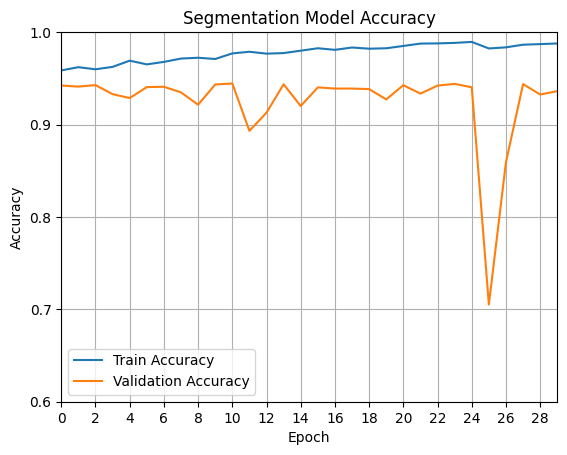

In [15]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Segmentation Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xlim(0, len(history.history['accuracy']) - 1)
plt.ylim(0.6, 1.0)

plt.xticks(range(0, len(history.history['accuracy']), 2))  # Tick every 2 epochs
plt.yticks([0.6, 0.7, 0.8, 0.9, 1.0])

plt.grid(True)
plt.legend()
plt.show()


# Make Predictions

- Make predictions on the test data

In [16]:
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=-1)
y_true_class = np.argmax(y_test, axis=-1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


# Visualize Batch

- Shows 5 samples:
 - Input image
 - Ground truth mask
 - Predicted mask (color-coded using jet colormap)

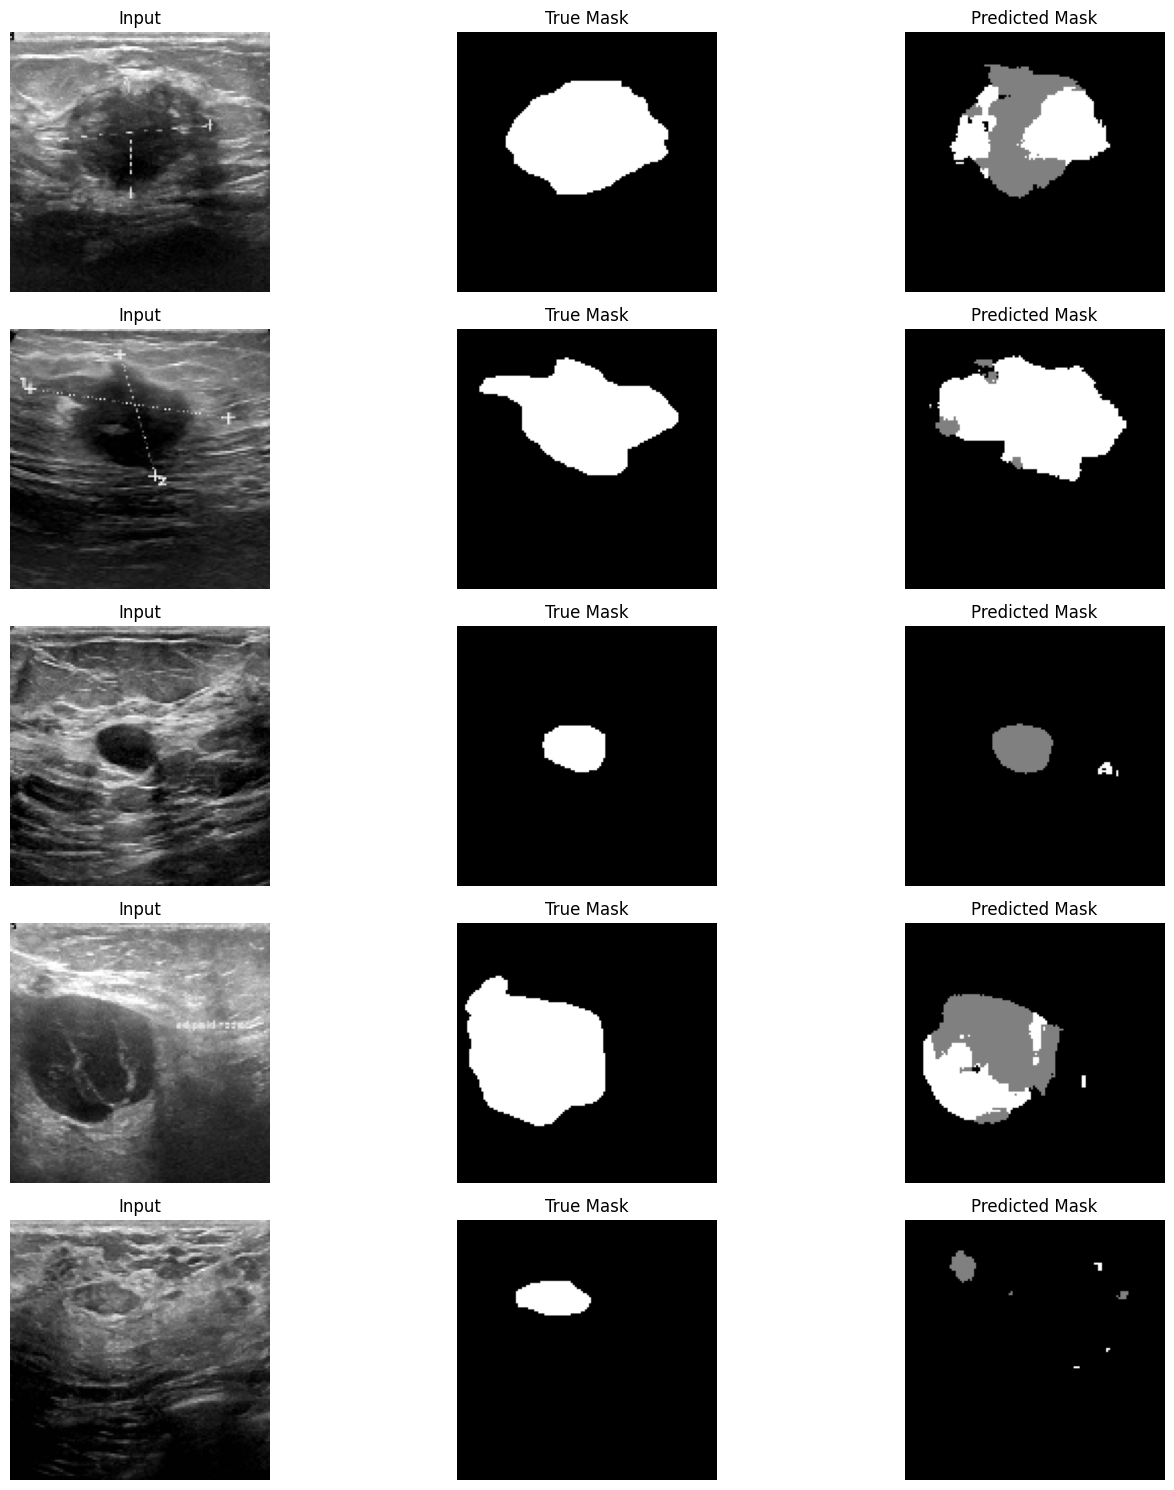

In [17]:
def visualize_batch(X_batch, y_true_batch, y_pred_batch, n=5):
    """
    Visualizes a batch of n samples.
    - X_batch: input images (N, 128, 128, 1)
    - y_true_batch: one-hot encoded masks (N, 128, 128, 3)
    - y_pred_batch: one-hot or softmax predicted masks (N, 128, 128, 3)
    """
    y_true_class = np.argmax(y_true_batch, axis=-1)
    y_pred_class = np.argmax(y_pred_batch, axis=-1)

    plt.figure(figsize=(15, n * 3))
    for i in range(n):
        plt.subplot(n, 3, i*3+1)
        plt.imshow(X_batch[i].squeeze(), cmap='gray')
        plt.title("Input")
        plt.axis('off')

        plt.subplot(n, 3, i*3+2)
        plt.imshow(y_true_class[i], cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(n, 3, i*3+3)
        plt.imshow(y_pred_class[i], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_batch(X_test, y_test, y_pred, n=5)